# Лабораторна робота №11. Класифiкацiя зображень за допомогою нейромереж.
Для цієї лабораторної роботи необхідно використати набір даних <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> який доступний через <a href='https://pytorch.org/docs/stable/torchvision/index.html'>torchvision</a>. Цей датасет містить тренувальний набір з 60000 та тестовий набір з 10000 зображень. Кожне зображення є у сірому градієнті та має розміри 28х28. Набір розмічений у 10 значень, кожна міка має одне з наступних значеннь:

0. Футболка;
1. Штани;
2. Светр;
3. Плаття;
4. Плащ;
5. Сандалі;
6. Сорочка;
7. Кросівки;
8. Сумка;
9. Ботильйон;

## Імпорт необхідних біліотек та завантаження даних.

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

## Створіть Data Loader-и.

In [89]:
# пишіть код тут.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


## Дослідіть частину набору даних.
Використайте make_grid, DataLoader та matplotlob щоб показати перші 10 зображень. 
Додатково можете вивести і значення (label), які присвоєні тим зображенням.

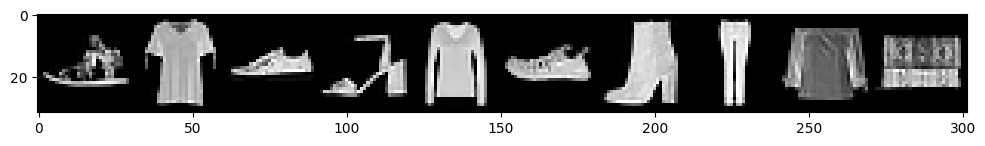

Labels: tensor([5, 6, 7, 5, 2, 5, 9, 1, 6, 8])
Class names: ['Sandal', 'Shirt', 'Sneaker', 'Sandal', 'Sweater', 'Sandal', 'Boot', 'Trouser', 'Shirt', 'Bag']


In [90]:
# пишіть код тут.

def show_images(images, labels):
    grid = make_grid(images, nrow=10)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
    print("Labels:", labels)
    print("Class names:", [class_names[label] for label in labels])

for images, labels in train_loader:
    show_images(images[:10], labels[:10])
    break

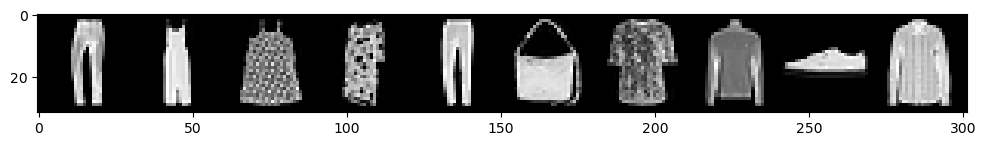

Label:  [4 0 9 4 0 9 1 5 9 3]
Class:  Coat T-shirt Boot Coat T-shirt Boot Trouser Sandal Boot Dress


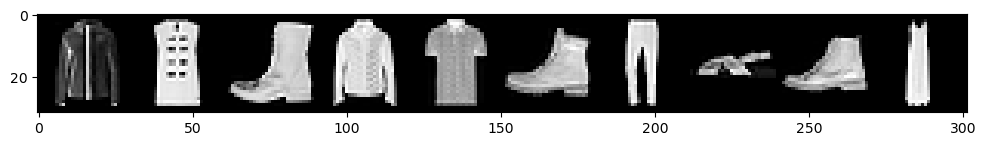

## Якщо зораження 28х28 пропустити через згортковий шар, використовуючи фільтр 5х5, `stride` 1 і без відступів, який буде розмір матриці ознак?

In [91]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1)
input_tensor = torch.randn(1, 1, 28, 28)
output_tensor = conv(input_tensor)
output_tensor.shape[2:]


torch.Size([24, 24])

## Якщо матрицю з попереднього кроку пропустити через матрицю 2x2 MaxPolling шар, який розмір буде мати матриця результат?

In [92]:
mxpoll = nn.MaxPool2d(kernel_size= 2, stride=2)
output_tensor = mxpoll(output_tensor)
output_tensor.shape[2:]

torch.Size([12, 12])

# Створення згорткової нейроної мережі.
## Створіть клас згорткової нейронної мережі.
Модель має мати два згорткових шари, два шари для отримання ознак і два повністю з'єднанних шари. Будь яка кількість нейронів у шарах може бути використана, але мережа на вхід має приймати зображення 28х28 та на виході мати 10 нейронів.

In [103]:
## Створіть клас згорткової нейронної мережі.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f' {device}')

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
torch.manual_seed(101)
model = ConvolutionalNetwork().to(device)
print(model)

 cuda
ConvolutionalNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


## Скільки параметрів, які будуть тренуватись у вашій моделі?

In [104]:
parameters = list(model.parameters())
print(len(parameters))

res = 0
for param in parameters:
    if param.requires_grad:
        res += param.numel()

print(res)

8
108618


## Визначте функцію втрат та оптимізатор.

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Натренуйте модель.

In [106]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
                    accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')          

epoch:  0  batch:  600 [  6000/60000]  loss: 0.96088284                      accuracy:  63.017%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.92808354                      accuracy:  69.033%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.26625746                      accuracy:  71.850%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.77233833                      accuracy:  73.562%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.66473293                      accuracy:  74.870%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.23515594                      accuracy:  75.939%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.22447324                      accuracy:  76.864%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.32862329                      accuracy:  77.548%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.75096363                      accuracy:  78.130%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.11980028                      accuracy:  78.668%
epoch:  1  batch:  600 [  6000/60000]  l

##  Оцініть модель.

In [111]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_val = model(X_test)
        y_test = y_test.to(device)
        y_val = y_val.to(device)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8746/10000 =  87.460%
